In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import gc
import os


# 시각화 관련 설정
try:
    plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
except:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False
fm._load_fontmanager(try_read_cache=False)


# 디바이스 설정
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps") # 맥 GPU
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda:0") # 윈도우 GPU
else:
    DEVICE = torch.device("cpu") # CPU


# 캐시 지우기 함수 생성
def clean_cache():
    gc.collect()
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()

# MallocStackLogging 에러 출력 방지
os.environ.pop("MallocStackLogging", None)
os.environ.pop("MallocStackLoggingNoCompact", None)
os.environ.pop("DYLD_INSERT_LIBRARIES", None)


# # 로그
# import logging

# def init_logger() -> logging.Logger:
#     logging.basicConfig(
#         format="%(asctime)s [%(levelname)s] (%(filename)s:%(lineno)d) - %(message)s",
#         datefmt="%Y-%m-%d %H:%M:%S",
#         level=logging.INFO,
#         encoding="utf-8",
#     )
#     return logging.getLogger("")

# logger = init_logger()

Matplotlib is building the font cache; this may take a moment.


In [ ]:
import glob

IMAGE_BASE_PATH = "./data/train_images"
image_paths = sorted(glob.glob(f"{IMAGE_BASE_PATH}/*.png"))
print(f"· 이미지 파일: {len(image_paths)}개")


ANNOT_BASE_PATH = "./data/train_annotations"

annot_folders = [folder for folder in sorted(glob.glob(f"{ANNOT_BASE_PATH}/*"))
                if folder.split("/")[-1].startswith("K-")]

annot_sub_folders = []

for subfolder in annot_folders:
    if subfolder.split("/")[-1].startswith("K-"):
        annot_sub_folders.extend(sorted(glob.glob(f"{subfolder}/*")))

annot_paths = []

for file in annot_sub_folders:
    if file.split("/")[-1].startswith("K-"):
        annot_paths.extend(sorted(glob.glob(f"{file}/*.json")))
        
print(f"· 어노테이션 파일: {len(annot_paths)}개")

· 이미지 파일: 651개
· 어노테이션 파일: 1001개


In [ ]:
# 전체 / 일부 / 결손 데이터 나누기

FULL_DICT = dict()
PARTIAL_DICT = dict()
NO_DICT = dict()
only_annot_set = set(annot_paths)

for image_path in image_paths:
    image_name = image_path.split("./data/train_images/")[1].split(".")[0]
    image_simple_name = image_name.split("_0_2_0_2")[0]

    pill_nums = image_simple_name.split("K-")[1].split("-")
    pill_count = len(pill_nums)
    count = 0
    tmp_list = []

    for pill_num in pill_nums:
        annot_path = f"{ANNOT_BASE_PATH}/{image_simple_name}_json/K-{pill_num}/{image_name}.json"

        if annot_path in annot_paths:
            tmp_list.append(annot_path)
            only_annot_set.remove(annot_path)
            count += 1
    
    if count == pill_count:
        FULL_DICT[image_path] = tmp_list
    elif count == 0:
        NO_DICT[image_path] = tmp_list
    else:
        PARTIAL_DICT[image_path] = tmp_list

print(f"[파일명 기준]")
print(f"· 이미지 내 알약의 어노테이션 모두 존재: 이미지 {len(FULL_DICT)}개 | 어노테이션 {sum([len(a) for a in FULL_DICT.values()])}개")
print(f"· 이미지 내 알약의 어노테이션 일부 존재: 이미지 {len(PARTIAL_DICT)}개 | 어노테이션 {sum([len(a) for a in PARTIAL_DICT.values()])}개")
print(f"· 이미지 내 알약의 어노테이션 전혀 없음: 이미지 {len(NO_DICT)}개 | 어노테이션 {sum([len(a) for a in NO_DICT.values()])}개")
print(f"· 이미지 없이 어노테이션만 존재: {len(only_annot_set)}개")

[파일명 기준]
· 이미지 내 알약의 어노테이션 모두 존재: 이미지 220개 | 어노테이션 734개
· 이미지 내 알약의 어노테이션 일부 존재: 이미지 8개 | 어노테이션 17개
· 이미지 내 알약의 어노테이션 전혀 없음: 이미지 423개 | 어노테이션 0개
· 이미지 없이 어노테이션만 존재: 250개


In [ ]:
# 클래스 개수 파악

json_folder_list = [path_list for path_list in FULL_DICT.values()]

tmp_list = []

for a in json_folder_list:
    tmp_list.extend(a)

pill_num_set = set()
pill_num_count_dict = dict()

for folder_name in tmp_list:
    folder_name = folder_name.split("_json")[0]
    name_list = folder_name.split("-")[1:]

    for name in name_list:
        pill_num_set.add(name)
        

for pill_num in pill_num_set:
    for name in FULL_DICT.keys():
        if name.find(pill_num) != -1:
            try:
                pill_num_count_dict[pill_num] += 1
            except:
                pill_num_count_dict[pill_num] = 1      

print(f"· 총 약 종류: {len(pill_num_set)}개")

· 총 약 종류: 56개


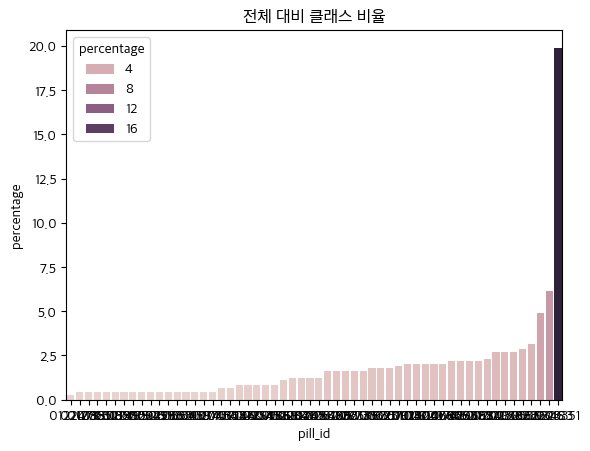

In [ ]:
# 클래스 구성 비율 파악
import pandas as pd
import seaborn as sns

pill_df = pd.DataFrame(columns=["pill_id", "count", "percentage"])

for key, value in pill_num_count_dict.items():
    pill_df.loc[len(pill_df)] = key, value, value/sum([len(a) for a in FULL_DICT.values()]) * 100

pill_df = pill_df.sort_values("count")

sns.barplot(pill_df, x="pill_id", y="percentage", hue="percentage")
plt.title("전체 대비 클래스 비율")
plt.show()

In [ ]:
pill_df

,pill_id,count,percentage
22,012247,2,0.272480
27,021771,3,0.408719
23,012081,3,0.408719
24,019552,3,0.408719
17,033009,3,0.408719
16,031885,3,0.408719
54,013395,3,0.408719
14,024850,3,0.408719
12,027926,3,0.408719
29,029451,3,0.408719


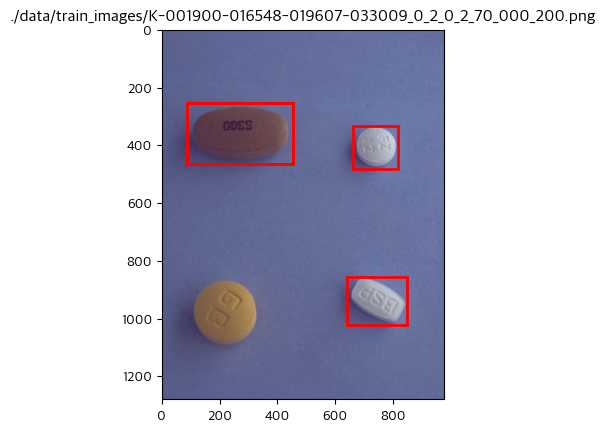

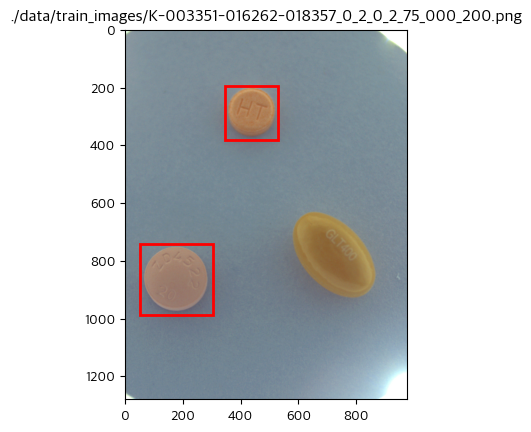

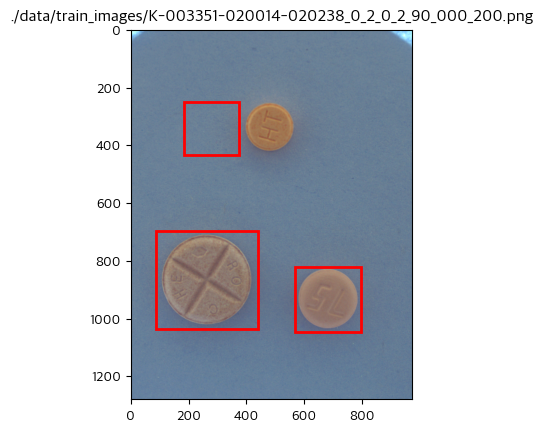

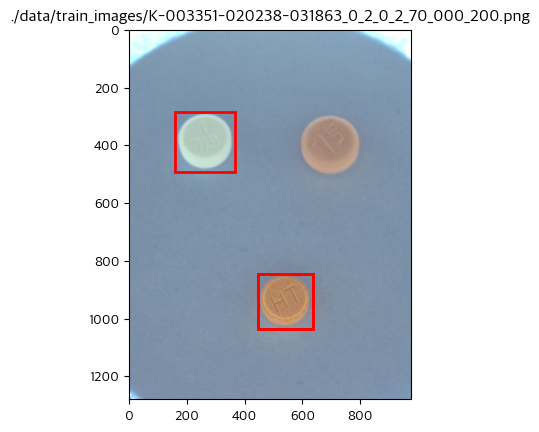

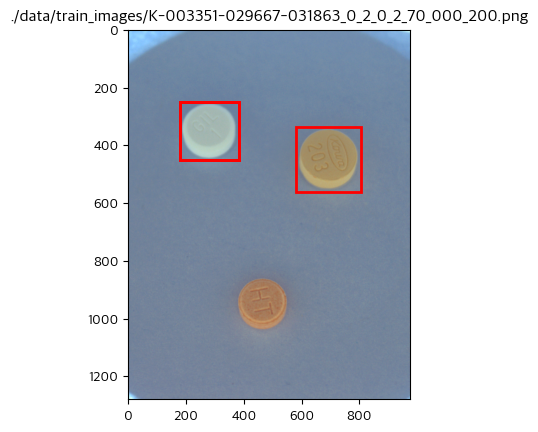

In [ ]:
# 에러 이미지 출력

import torchvision
import matplotlib.patches as patches
import json

with open("./data/err_image_paths.txt", "r", encoding="utf-8") as f:
    err_image_paths = f.read().split()

for img in err_image_paths:
    sample_bbox = []

    for annot_path in FULL_DICT[img]:
        with open(annot_path, 'r', encoding='utf-8') as f:
            json_data = json.load(f)
        sample_bbox.append({
                        "bbox": json_data["annotations"][0]["bbox"],
                        "label": json_data["images"][0]["drug_N"]
                        })

    image = torchvision.io.read_image(img).permute(1,2,0)

    fig, ax = plt.subplots()

    plt.title(f"{img}")
    plt.imshow(image)

    for bbox_dict in sample_bbox:
        x, y, w, h = bbox_dict["bbox"][0], bbox_dict["bbox"][1], bbox_dict["bbox"][2], bbox_dict["bbox"][3]
        rectangle = patches.Rectangle((x, y), w, h, color="red", fill=False, linewidth=2)
        ax.add_patch(rectangle)

    plt.show()

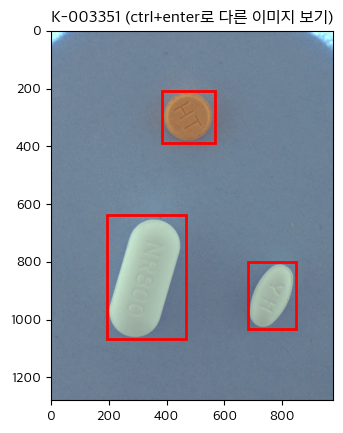

In [ ]:
# 랜덤 샘플 이미지 출력

import matplotlib.patches as patches
import random

rand_idx = random.randint(1, len(FULL_DICT))

sample_image_path = list(FULL_DICT.keys())[rand_idx-1]

sample_bbox = []

for annot_path in FULL_DICT[sample_image_path]:
    with open(annot_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    sample_bbox.append({
                    "bbox": json_data["annotations"][0]["bbox"],
                    "label": json_data["images"][0]["drug_N"]
                    })

image = torchvision.io.read_image(sample_image_path).permute(1,2,0)

fig, ax = plt.subplots()

plt.title(f"{sample_bbox[0]['label']} (ctrl+enter로 다른 이미지 보기)")
plt.imshow(image)

for bbox_dict in sample_bbox:
    x, y, w, h = bbox_dict["bbox"][0], bbox_dict["bbox"][1], bbox_dict["bbox"][2], bbox_dict["bbox"][3]
    rectangle = patches.Rectangle((x, y), w, h, color="red", fill=False, linewidth=2)
    ax.add_patch(rectangle)

plt.show()